# Домашнее задание по теме "Многослойная нейронная сеть"

## Заданиие

Постройте модель на основе полносвязных слоёв для классификации Fashion MNIST из библиотеки torchvision ([datasets](https://pytorch.org/vision/stable/datasets.html)).
Получите качество на тестовой выборке **не ниже 88%**

**Инструкция по выполнению задания**

- Скачайте тренировочную и тестовою часть датасета Fashion MNIST
- Постройте модель, выбрав стартовую архитектуру
- Обучите модель и сверьте качество на тестовой части с заданным порогом
- Изменяйте архитектуру модели пока качество на тестовой части не будет выше порога. Вариации архитектуры можно реализовать через изменение количества слоёв, количества нейронов в слоях и использование регуляризации. Можно использовать различные оптимизаторы.

## Решение

### Загрузка датасета

In [33]:
import torch
import torchvision as tv
from torchsummary import summary
import numpy as np
import time
import matplotlib.pyplot as plt

In [13]:
train_dataset = tv.datasets.FashionMNIST('./datas', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.FashionMNIST('./datas', train=False, transform=tv.transforms.ToTensor(), download=True)

In [4]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./datas
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_dataset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./datas
    Split: Test
    StandardTransform
Transform: ToTensor()

In [50]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

Посмотрим, что это за картинки:

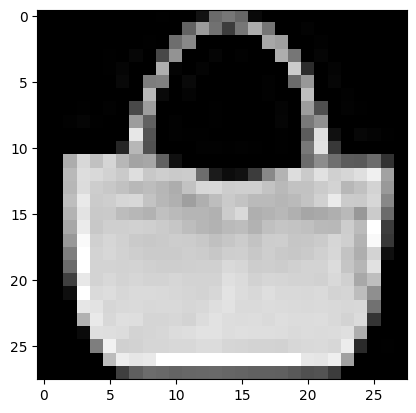

In [44]:
plt.imshow(train_dataset[100][0].numpy().reshape(28, 28), cmap='gray')

In [ ]:
BATCH_SIZE = 256

In [8]:
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

### Построение модели

In [10]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10)
)

In [11]:
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

In [15]:
summary(model, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                   [-1, 10]           2,570
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.78
Estimated Total Size (MB): 0.79
----------------------------------------------------------------


### Обучение модели

#### Вспомогательные функции

Функция для оценки качества работы модели

In [19]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = torch.Tensor([0]), 0
    for X, y in data_iter:
        acc_sum +=(net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n    

Функция обечения модели

In [ ]:
def train(net, train_iter, test_iter, optimizer, num_epochs):
    loss = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for X, y in train_iter:
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

        test_acc = evaluate_accuracy(test_iter, net)
        print(f"epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}" \
              f", test acc {test_acc:.3f}, time {time.time() - start:.1f} sec")    


#### Обучение model_v_0

Гиперпараметры

In [22]:
lr, num_epochs = .01, 10
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [23]:
train(
    model,
    train_iter=train_iter,
    test_iter=test_iter,
    optimizer=optimizer,
    num_epochs=num_epochs
)

epoch 1, loss 0.0069, train acc 0.559, test acc 0.648, time 16.9 sec
epoch 2, loss 0.0042, train acc 0.668, test acc 0.672, time 15.4 sec
epoch 3, loss 0.0034, train acc 0.700, test acc 0.704, time 16.4 sec
epoch 4, loss 0.0030, train acc 0.734, test acc 0.734, time 15.7 sec
epoch 5, loss 0.0028, train acc 0.757, test acc 0.754, time 16.2 sec
epoch 6, loss 0.0026, train acc 0.774, test acc 0.770, time 16.2 sec
epoch 7, loss 0.0025, train acc 0.787, test acc 0.780, time 16.6 sec
epoch 8, loss 0.0024, train acc 0.796, test acc 0.788, time 15.9 sec
epoch 9, loss 0.0023, train acc 0.803, test acc 0.794, time 16.8 sec
epoch 10, loss 0.0022, train acc 0.809, test acc 0.800, time 15.9 sec


**Вывод**
1. Модель недообучена.
1. Возможно, если увеличить число эпох, то качество улучшится, но мы пойдем другим путем.

#### Обучение model_v_1

In [26]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10)
)

Изменим оптимизатор с SGD на Adam:

In [27]:
lr, num_epochs = .01, 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [28]:
train(
    model,
    train_iter=train_iter,
    test_iter=test_iter,
    optimizer=optimizer,
    num_epochs=num_epochs
)

epoch 1, loss 0.0021, train acc 0.808, test acc 0.838, time 45.6 sec
epoch 2, loss 0.0015, train acc 0.861, test acc 0.846, time 44.9 sec
epoch 3, loss 0.0014, train acc 0.870, test acc 0.859, time 44.8 sec
epoch 4, loss 0.0013, train acc 0.879, test acc 0.865, time 45.0 sec
epoch 5, loss 0.0012, train acc 0.883, test acc 0.864, time 44.8 sec
epoch 6, loss 0.0012, train acc 0.888, test acc 0.866, time 45.1 sec
epoch 7, loss 0.0012, train acc 0.891, test acc 0.868, time 45.0 sec
epoch 8, loss 0.0011, train acc 0.893, test acc 0.866, time 45.8 sec
epoch 9, loss 0.0011, train acc 0.895, test acc 0.867, time 46.0 sec
epoch 10, loss 0.0011, train acc 0.897, test acc 0.874, time 45.5 sec


**Вывод**
1. Обучение проходит значительно медленнее.
1. Но результаты лучше.
1. Качество модели еще не достигло заданного значения.

#### Обучение model v_2

Увеличим глубину модели:

In [30]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128), 
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10)
)

In [31]:
lr, num_epochs = .01, 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [32]:
train(
    model,
    train_iter=train_iter,
    test_iter=test_iter,
    optimizer=optimizer,
    num_epochs=num_epochs
)

epoch 1, loss 0.0024, train acc 0.777, test acc 0.840, time 53.5 sec
epoch 2, loss 0.0015, train acc 0.855, test acc 0.855, time 53.4 sec
epoch 3, loss 0.0014, train acc 0.866, test acc 0.858, time 53.4 sec
epoch 4, loss 0.0013, train acc 0.872, test acc 0.865, time 55.4 sec
epoch 5, loss 0.0013, train acc 0.880, test acc 0.860, time 54.9 sec
epoch 6, loss 0.0013, train acc 0.882, test acc 0.862, time 54.9 sec
epoch 7, loss 0.0012, train acc 0.886, test acc 0.864, time 54.3 sec
epoch 8, loss 0.0012, train acc 0.890, test acc 0.857, time 54.5 sec
epoch 9, loss 0.0011, train acc 0.892, test acc 0.858, time 53.3 sec
epoch 10, loss 0.0011, train acc 0.894, test acc 0.870, time 53.4 sec


**Вывод**
1. Результать лучше не стал.
1. Появились признаки переобучения.

#### Обучение model v_3

Применим Batch-нормализацию:

In [60]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 512),
    torch.nn.BatchNorm1d(512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.BatchNorm1d(256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.BatchNorm1d(128), 
    torch.nn.ReLU(),
    torch.nn.Linear(128, 64),
    torch.nn.BatchNorm1d(64), 
    torch.nn.ReLU(),
    torch.nn.Linear(64, 10),

)

In [61]:
lr, num_epochs = .01, 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [62]:
train(
    model,
    train_iter=train_iter,
    test_iter=test_iter,
    optimizer=optimizer,
    num_epochs=num_epochs
)

epoch 1, loss 0.0019, train acc 0.818, test acc 0.849, time 14.3 sec
epoch 2, loss 0.0014, train acc 0.869, test acc 0.860, time 15.5 sec
epoch 3, loss 0.0012, train acc 0.885, test acc 0.868, time 13.7 sec
epoch 4, loss 0.0011, train acc 0.896, test acc 0.872, time 13.5 sec
epoch 5, loss 0.0010, train acc 0.904, test acc 0.871, time 13.8 sec
epoch 6, loss 0.0009, train acc 0.911, test acc 0.877, time 13.2 sec
epoch 7, loss 0.0009, train acc 0.918, test acc 0.874, time 12.4 sec
epoch 8, loss 0.0008, train acc 0.922, test acc 0.880, time 13.2 sec
epoch 9, loss 0.0008, train acc 0.928, test acc 0.880, time 13.6 sec
epoch 10, loss 0.0007, train acc 0.931, test acc 0.884, time 12.9 sec


**Вывод**
1. Модель обучается быстрее.
1. Признаков переобучения нет.
1. Результат на тестовой выборке соответствует заданному конторльному значению качества модели.

#### Обучение model v_4

Применим Dropout-регуляризацию

In [117]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 1568),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(1568, 784),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(784, 392),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(392, 10),
)

In [118]:
lr, num_epochs = .01, 30
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [119]:
train(
    model,
    train_iter=train_iter,
    test_iter=test_iter,
    optimizer=optimizer,
    num_epochs=num_epochs
)

epoch 1, loss 0.0088, train acc 0.223, test acc 0.265, time 28.1 sec
epoch 2, loss 0.0075, train acc 0.367, test acc 0.443, time 28.5 sec
epoch 3, loss 0.0052, train acc 0.527, test acc 0.570, time 24.3 sec
epoch 4, loss 0.0042, train acc 0.597, test acc 0.612, time 29.2 sec
epoch 5, loss 0.0036, train acc 0.646, test acc 0.656, time 28.5 sec
epoch 6, loss 0.0033, train acc 0.676, test acc 0.684, time 27.3 sec
epoch 7, loss 0.0031, train acc 0.700, test acc 0.705, time 26.3 sec
epoch 8, loss 0.0029, train acc 0.720, test acc 0.722, time 27.3 sec
epoch 9, loss 0.0028, train acc 0.736, test acc 0.736, time 26.5 sec
epoch 10, loss 0.0027, train acc 0.752, test acc 0.749, time 26.2 sec
epoch 11, loss 0.0026, train acc 0.763, test acc 0.756, time 26.7 sec
epoch 12, loss 0.0025, train acc 0.773, test acc 0.763, time 27.2 sec
epoch 13, loss 0.0024, train acc 0.780, test acc 0.777, time 26.9 sec
epoch 14, loss 0.0024, train acc 0.788, test acc 0.780, time 26.5 sec
epoch 15, loss 0.0023, train 

**Вывод**
1. Комбинация SGD и Dropout-регуляризации дало в результате хорошее качество модели, хотя для этого понадобилось значитально больше эпох.
1. Обучение шло быстрее.
1. Показатели качества модели менялись медленно, но верно, без признаков переобучения модели.
1. Но до требуемых значений дотянуть не удалось... Вероятно, потребовалось бы ещё больше эпох.

### Заключение

Использование оптимизатора Adam в сочетании с Batch-нормализацией позволило по прошествии 10-и эпох получить accuracy на тестовтй выборке более 88%
